In [109]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
import glob
from scipy.optimize import minimize, curve_fit
from scipy.stats import mode

import george
from george import kernels
from george.modeling import Model

Initial ln-likelihood: -11.82
      fun: 9.225282556043904
 hess_inv: array([[0.52320809, 0.30041273],
       [0.30041273, 0.40708074]])
      jac: array([-5.07047667e-06,  2.56077808e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([-0.48730733,  0.60407551])

Final ln-likelihood: -9.23


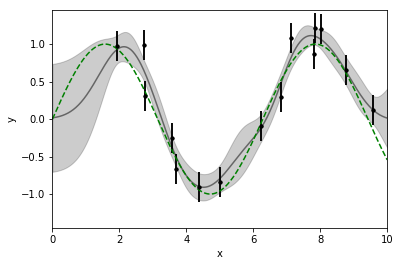

In [14]:
np.random.seed(1234)
x = 10 * np.sort(np.random.rand(15))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x_pred, np.sin(x_pred), "--g")
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

In [15]:
def create_datafilename(sol, dr='/Users/brian/Downloads/ps_bundle/data_calibrated'):
    filenames = glob.glob(dr + "/*/*_calib_*.csv")
    
    # file names have some zeros and then the sol number; Add the right number of zeros
    file_stem = ""
    for i in range(4 - len(str(sol))):
        file_stem += "0"
    file_stem += str(sol)
    
    res = [i for i in filenames if str(file_stem) + "_01" in i] 
    return res

def convert_ltst(sol_data):
    LTST = np.zeros(sol_data['LTST'].size)
    LTST_and_sol = np.zeros(sol_data['LTST'].size)
    
    for i in range(len(sol_data['LTST'])):
        sol, time = sol_data['LTST'][i].decode("utf-8").split()
        hr, mn, sc = time.split(":")
        
        cur_LTST = float(hr) + float(mn)/60. + float(sc)/3600.
        LTST[i] = cur_LTST
        LTST_and_sol[i] = float(sol)*24. + cur_LTST
        
    return LTST, LTST_and_sol

def retrieve_vortices(sol, sol_filename, Spigas_data, window_width=30./3600):
    sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)
    LTST, LTST_and_sol = convert_ltst(sol_data)

    vortices = []
    
    ind = Spigas_data['SOL'] == sol
    for time in Spigas_data['_LTST_'][ind]:
        x = LTST - time
        time_ind = np.abs(x) < window_width # convert from 
        vortices.append([x[time_ind], sol_data['PRESSURE'][time_ind]])
                                           
    return vortices

def modified_lorentzian(t, baseline, slope, t0, DeltaP, Gamma):
    # Equation 7 from Kahapaa+ (2016)
    return baseline + slope*(t - t0) - DeltaP/(((t - t0)/(Gamma/2.))**2 + 1)

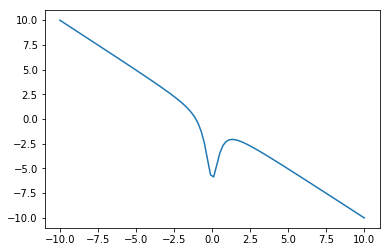

In [16]:
t = np.linspace(-10., 10., 100)
baseline = 0.
slope = -1.
t0 = 0.
DeltaP = 6.
Gamma = 1.

plt.plot(t, modified_lorentzian(t, baseline, slope, t0, DeltaP, Gamma))

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


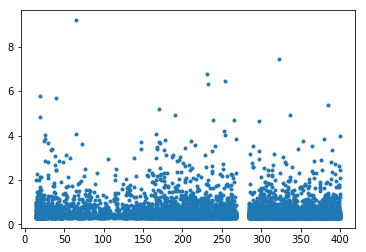

In [17]:
filename = "alldrop_ordered.txt"
Spigas_data = np.genfromtxt(filename, names=True, delimiter=";", dtype=None)

# _DROP_ ; _LTST_ ; SOL ; YYYY-MM-DDTHH:MM:SS.sss ; RATIO
plt.plot(Spigas_data['SOL'], -Spigas_data['_DROP_'], marker='.', ls='')

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """


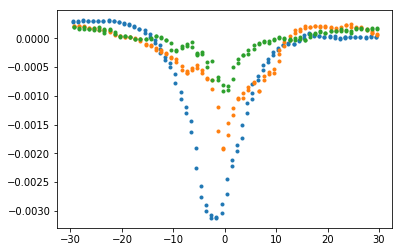

In [18]:
sol = 15
sol_filename = create_datafilename(sol)

# AOBT SCLK LMST LTST UTC PRESSURE PRESSURE_FREQUENCY PRESSURE_TEMP PRESSURE_TEMP_FREQUENCY
sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)
LTST, LTST_and_sol = convert_ltst(sol_data)

ind = Spigas_data['SOL'] == sol
for time in Spigas_data['_LTST_'][ind][0:3]:
    x = LTST - time
    time_ind = np.abs(x) < 30/3600.
    md = np.nanmedian(sol_data['PRESSURE'][time_ind])
    plt.plot(x[time_ind]*3600., (sol_data['PRESSURE'][time_ind] - md)/md, marker='.', ls='')

In [19]:
vortices = retrieve_vortices(sol, sol_filename, Spigas_data)

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


15
733.4161999999999 -6.992542372881145 0.0 1.5063999999998714 0.0002777777777777778
[7.33525696e+02 5.39894555e+00 1.86811521e-04 1.23881338e+00
 3.81697791e-03]
[2.21347142e-02 2.23029476e+00 5.56562737e-05 3.62117914e-02
 2.24718002e-04]


/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


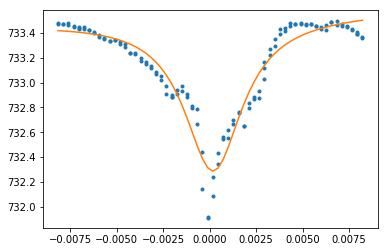

In [20]:
print(len(Spigas_data['SOL'][Spigas_data['SOL'] == sol]))
which_vortex = 1

plt.plot(vortices[which_vortex][0][:], vortices[which_vortex][1][:], marker='.', ls='')

# modified_lorentzian(t, baseline, slope, t0, DeltaP, Gamma)
init_baseline = 0.5*(vortices[which_vortex][1][0] + vortices[which_vortex][1][-1])
init_slope = (vortices[which_vortex][1][-1] - vortices[which_vortex][1][0])/\
    (vortices[which_vortex][0][-1] - vortices[which_vortex][0][0])
init_t0 = 0.
init_DeltaP = init_baseline - np.min(vortices[which_vortex][1][:])
init_Gamma = 1./3600.

print(init_baseline, init_slope, init_t0, init_DeltaP, init_Gamma)
popt, pcov = curve_fit(modified_lorentzian, vortices[which_vortex][0][:], vortices[which_vortex][1][:], 
                      p0=[init_baseline, init_slope, init_t0, init_DeltaP, init_Gamma])
print(popt)
print(np.diag(np.sqrt(pcov)))

plt.plot(vortices[which_vortex][0][:], modified_lorentzian(vortices[which_vortex][0][:], *popt))

In [42]:
# 2020 Jun 16 - Trying George instead - https://george.readthedocs.io/en/latest/tutorials/model/
class Modified_Lorentzian_Model(Model):
    parameter_names = ("baseline", "slope", "t0", "DeltaP", "Gamma")

    def get_value(self, t):
        shifted_time = t - self.t0 
        return self.baseline + self.slope*(shifted_time) - self.DeltaP/(((shifted_time)/(self.Gamma/2.))**2 + 1)

In [94]:
t = vortices[which_vortex][0][:]
y = vortices[which_vortex][1][:]

# Assume the error is roughly the point-to-point difference
yerr = np.median(np.abs(y[1:] - y[0:-1]))*np.ones_like(y)
print(yerr[0])
model = george.GP(mean=Modified_Lorentzian_Model(baseline=0, slope=0, t0=0, DeltaP=1.5, Gamma=10./3600))
model.compute(t, yerr)

def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()

0.016200000000026193


In [63]:
import emcee

initial = model.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running burn-in...
Running production...


In [103]:
kwargs = dict(baseline=np.max(y), slope=0, t0=0, DeltaP=1.5, Gamma=10./3600)
kwargs["bounds"] = dict(baseline=(0.5*np.min(y), 2.*np.max(y)), 
                        slope=(-20.*np.abs(init_slope), 20.*np.abs(init_slope)), t0=(np.min(t), np.max(t)), 
                        DeltaP=(0., 50.), Gamma=(0, np.max(t) - np.min(t)))
mean_model = Modified_Lorentzian_Model(**kwargs)
gp = george.GP(np.var(y) * kernels.Matern32Kernel(10.0), mean=mean_model)
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()

In [104]:
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000);

Running first burn-in...
Running second burn-in...
Running production...


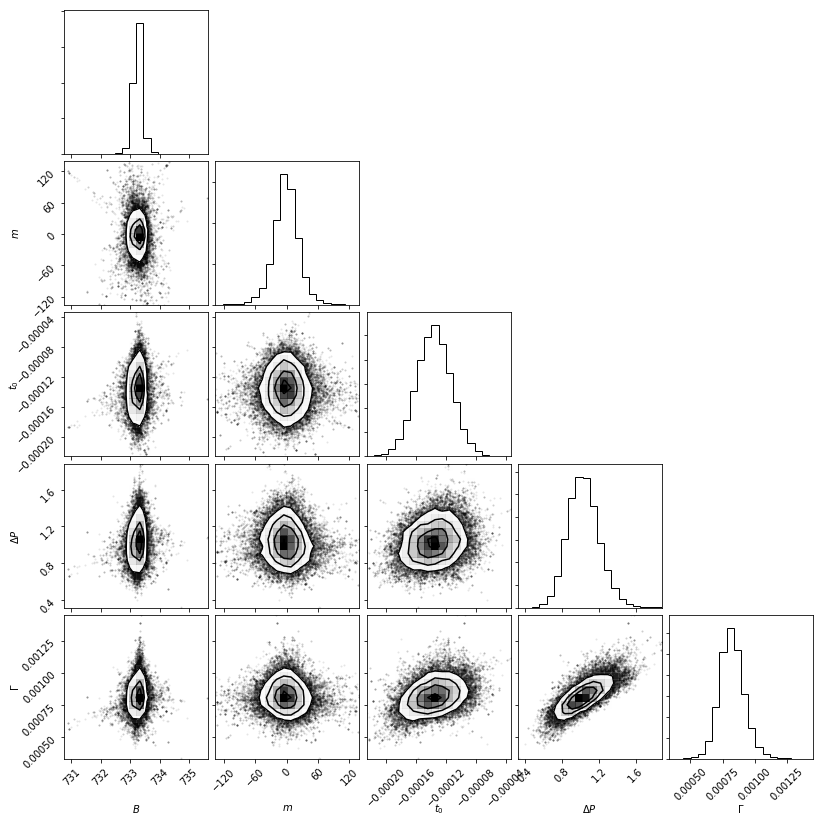

In [105]:
import corner

tri_cols = ["baseline", "slope", "t0", "DeltaP", "Gamma"]
tri_labels = [r"$B$", r"$m$", r"$t_0$", r"$\Delta P$", r"$\Gamma$"]
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], labels=tri_labels);

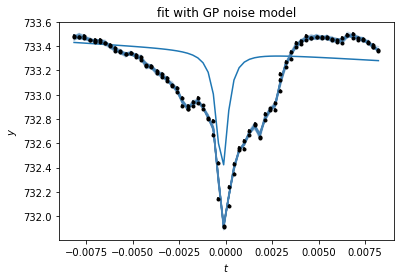

In [134]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

samples = sampler.flatchain
vals = mode(samples, axis=0).mode[0]
pl.plot(t, modified_lorentzian(t, vals[0], vals[1], vals[2], vals[3], vals[4]))

# The positions where the prediction should be computed.

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, t)
    pl.plot(t, mu, color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
# pl.xlim(-5, 5)
pl.title("fit with GP noise model");